# Version check

In [12]:
!pip list

Package                 Version
----------------------- -----------
arro3-core              0.5.1
asttokens               3.0.0
certifi                 2025.8.3
charset-normalizer      3.4.3
chdb                    3.5.0
comm                    0.2.3
daft                    0.5.19
datafusion              48.0.0
debugpy                 1.8.16
decorator               5.2.1
delta-spark             3.2.0
deltalake               1.1.4
Deprecated              1.2.18
duckdb                  1.3.2
executing               2.2.0
fsspec                  2025.7.0
idna                    3.10
importlib_metadata      8.7.0
ipykernel               6.30.1
ipython                 9.4.0
ipython_pygments_lexers 1.1.1
jedi                    0.19.2
jupyter_client          8.6.3
jupyter_core            5.8.1
matplotlib-inline       0.1.7
nest-asyncio            1.6.0
numpy                   2.3.2
packaging               25.0
pandas                  2.3.1
parso                   0.8.4
pexpect               

In [2]:
source             = "/home/boor/data-playground/notebooks/light-etl-python/lakehouse/default/Files/0_Source/ARCHIVE/Daily_Reports/"
destination        = "/home/boor/data-playground/notebooks/light-etl-python/lakehouse/default/Files/1_Transform/0/ARCHIVE/Daily_Reports/"

nbr_copies         = 0
total_files        = 60 * (nbr_copies +1)

output_path        = f"/home/boor/data-playground/notebooks/light-etl-python/lakehouse/default/Tables/T{total_files}/"
performance_result = "/home/boor/data-playground/notebooks/light-etl-python/lakehouse/default/Tables/dbo/results"

In [4]:
import daft
import duckdb
import glob
import multiprocessing
import os
import pandas as pd
import polars as pl
import pyarrow         as pa
import pyarrow.compute as pc
import pyarrow.dataset as ds
import pyarrow.parquet as pq
import re
import requests
import shutil
import time

from   chdb import session as chs
from   daft import DataType, col
from   datafusion import SessionContext as session
from   datetime import datetime
from   deltalake.writer import write_deltalake
from   psutil import *
from   pyarrow         import csv
from   shutil import unpack_archive
from   urllib.request import urlopen
from   delta import *

In [8]:
core = cpu_count()
v_cpu = str(core) + " v_cpu"
mem = round(virtual_memory().total/(1024 * 1024 * 1024),0)
print(v_cpu +', memory: '+ str(mem))

16 v_cpu, memory: 63.0


In [11]:
def download(url,Path):
    if not os.path.exists(Path):
      os.makedirs(Path, exist_ok=True)
    result = urlopen(url).read().decode('utf-8')
    pattern = re.compile(r'[\w.]*.zip')
    filelist1 = pattern.findall(result)
    filelist_unique = dict.fromkeys(filelist1)
    filelist =sorted(filelist_unique, reverse=True)
    current =  [os.path.basename(x) for x in glob.glob(Path+'*.zip')]
    files_to_upload = list(set(filelist) - set(current))
    files_to_upload = list(dict.fromkeys(files_to_upload))
    print(str(len(files_to_upload)) + ' New File Loaded')
    if len(files_to_upload) != 0 :
      for x in files_to_upload:
           with requests.get(url+x, stream=True) as resp:
            if resp.ok:
              with open(f"{Path}{x}", "wb") as f:
               for chunk in resp.iter_content(chunk_size=4096):
                f.write(chunk)
    return "done"

def uncompress(x):
    unpack_archive(str(source+x), str(destination), 'zip')

def unzip(source, destination):
    if not os.path.exists(destination):
      os.makedirs(destination, exist_ok=True)
    filelist=[os.path.basename(x) for x in glob.glob(source+'*.zip')]
    current = [os.path.basename(x) for x in glob.glob(destination+'*.CSV')]
    current = [w.replace('.CSV','.zip') for w in current]
    files_to_upload = list(set(filelist) - set(current))
    files_to_upload = list(dict.fromkeys(files_to_upload))
    print(str(len(files_to_upload)) + ' New File uncompressed')
    if len(files_to_upload) != 0 :
      with multiprocessing.Pool() as pool:
       for _ in pool.imap_unordered(uncompress, files_to_upload, chunksize=1):
         pass
      return "done"
    else:
     return "nothing to see here"

In [29]:
def duckdb_clean_csv(x):
	con = duckdb.connect()
	con.sql(" SET preserve_insertion_order = false; ")
	raw =con.sql(F"""
	from read_csv({x},
	Skip=1,header =0,all_varchar=1,
	columns={{
	'I': 'VARCHAR','UNIT': 'VARCHAR','XX': 'VARCHAR','VERSION': 'VARCHAR','SETTLEMENTDATE': 'VARCHAR','RUNNO': 'VARCHAR',
	'DUID': 'VARCHAR','INTERVENTION': 'VARCHAR','DISPATCHMODE': 'VARCHAR','AGCSTATUS': 'VARCHAR','INITIALMW': 'VARCHAR',
	'TOTALCLEARED': 'VARCHAR','RAMPDOWNRATE': 'VARCHAR','RAMPUPRATE': 'VARCHAR','LOWER5MIN': 'VARCHAR',
	'LOWER60SEC': 'VARCHAR','LOWER6SEC': 'VARCHAR','RAISE5MIN': 'VARCHAR','RAISE60SEC': 'VARCHAR',
	'RAISE6SEC': 'VARCHAR','MARGINAL5MINVALUE': 'VARCHAR','MARGINAL60SECVALUE': 'VARCHAR',
	'MARGINAL6SECVALUE': 'VARCHAR','MARGINALVALUE': 'VARCHAR','VIOLATION5MINDEGREE': 'VARCHAR',
	'VIOLATION60SECDEGREE': 'VARCHAR','VIOLATION6SECDEGREE': 'VARCHAR','VIOLATIONDEGREE': 'VARCHAR',
	'LOWERREG': 'VARCHAR','RAISEREG': 'VARCHAR','AVAILABILITY': 'VARCHAR','RAISE6SECFLAGS': 'VARCHAR',
	'RAISE60SECFLAGS': 'VARCHAR','RAISE5MINFLAGS': 'VARCHAR','RAISEREGFLAGS': 'VARCHAR',
	'LOWER6SECFLAGS': 'VARCHAR','LOWER60SECFLAGS': 'VARCHAR','LOWER5MINFLAGS': 'VARCHAR',
	'LOWERREGFLAGS': 'VARCHAR','RAISEREGAVAILABILITY': 'VARCHAR','RAISEREGENABLEMENTMAX': 'VARCHAR',
	'RAISEREGENABLEMENTMIN': 'VARCHAR','LOWERREGAVAILABILITY': 'VARCHAR','LOWERREGENABLEMENTMAX': 'VARCHAR',
	'LOWERREGENABLEMENTMIN': 'VARCHAR','RAISE6SECACTUALAVAILABILITY': 'VARCHAR',
	'RAISE60SECACTUALAVAILABILITY': 'VARCHAR','RAISE5MINACTUALAVAILABILITY': 'VARCHAR',
	'RAISEREGACTUALAVAILABILITY': 'VARCHAR','LOWER6SECACTUALAVAILABILITY': 'VARCHAR',
	'LOWER60SECACTUALAVAILABILITY': 'VARCHAR','LOWER5MINACTUALAVAILABILITY': 'VARCHAR','LOWERREGACTUALAVAILABILITY': 'VARCHAR'
	}},
	filename =1,null_padding = true,ignore_errors=1,auto_detect=false)
	where I='D' and UNIT ='DUNIT' AND VERSION = 3                  """)

	df=con.sql("""
	select
	UNIT,
	DUID,
	filename,
	cast(columns(*exclude(DUID,UNIT,SETTLEMENTDATE,I,XX,filename)) as double),
	cast (SETTLEMENTDATE as TIMESTAMPTZ) as SETTLEMENTDATE,
	year (cast (SETTLEMENTDATE as timestamp)) as year  from raw
	""").record_batch()
	write_deltalake(output_path + 'duckdb',df,mode="overwrite",partition_by=['year'])
	return "done"

def spark_clean_csv(x):
  from pyspark.sql import SparkSession
  from pyspark.sql import functions as f
  spark = (SparkSession.builder
      .master("local[*]")
      .appName("DeltaApp")
      .config("spark.driver.memory", "63g")
      .config("spark.sql.shuffle.partitions", "16")
      .config("spark.sql.adaptive.enabled", "true")
      .config("spark.sql.adaptive.coalescePartitions.enabled", "true")
      .config("spark.ui.enabled", "false")
      .config("spark.eventLog.enabled", "false")
      .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension")
      .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog")
      .config("spark.jars.packages", "io.delta:delta-spark_2.12:3.2.0") \
      .getOrCreate())
  spark.sparkContext.setLogLevel("ERROR")
  user_schema="""
  I  STRING,UNIT  STRING,XX  STRING,VERSION  STRING,SETTLEMENTDATE  STRING,RUNNO  STRING,DUID  STRING,
  INTERVENTION  STRING,DISPATCHMODE  STRING,AGCSTATUS  STRING,INITIALMW  STRING,TOTALCLEARED  STRING,RAMPDOWNRATE  STRING,
  RAMPUPRATE  STRING,LOWER5MIN  STRING,LOWER60SEC  STRING,LOWER6SEC  STRING,RAISE5MIN  STRING,RAISE60SEC  STRING,RAISE6SEC  STRING,
  MARGINAL5MINVALUE  STRING,MARGINAL60SECVALUE  STRING,MARGINAL6SECVALUE  STRING,MARGINALVALUE  STRING,VIOLATION5MINDEGREE  STRING,
  VIOLATION60SECDEGREE  STRING,VIOLATION6SECDEGREE  STRING,VIOLATIONDEGREE  STRING,LOWERREG  STRING,RAISEREG  STRING,AVAILABILITY  STRING,
  RAISE6SECFLAGS  STRING,RAISE60SECFLAGS  STRING,RAISE5MINFLAGS  STRING,RAISEREGFLAGS  STRING,LOWER6SECFLAGS  STRING,LOWER60SECFLAGS STRING,
  LOWER5MINFLAGS  STRING,LOWERREGFLAGS  STRING,RAISEREGAVAILABILITY  STRING,RAISEREGENABLEMENTMAX  STRING,RAISEREGENABLEMENTMIN  STRING,
  LOWERREGAVAILABILITY  STRING,LOWERREGENABLEMENTMAX  STRING,LOWERREGENABLEMENTMIN  STRING,RAISE6SECACTUALAVAILABILITY  STRING,
  RAISE60SECACTUALAVAILABILITY  STRING,RAISE5MINACTUALAVAILABILITY  STRING,RAISEREGACTUALAVAILABILITY  STRING,
  LOWER6SECACTUALAVAILABILITY  STRING,LOWER60SECACTUALAVAILABILITY  STRING,LOWER5MINACTUALAVAILABILITY  STRING,
  LOWERREGACTUALAVAILABILITY  STRING,transactionId STRING
  """
  df = spark.read.format("csv")\
      .option("header","true") \
      .schema(user_schema)\
      .load(x)\
      .filter("unit='DUNIT' and version =3 and I='D'")\
      .drop('xx')\
      .drop('I')\
      .withColumn('SETTLEMENTDATE',f.to_timestamp('SETTLEMENTDATE','yyyy/MM/dd HH:mm:ss'))\
      .withColumn("file", f.regexp_extract(f.input_file_name(), r"Daily_Reports\/([^\W'\.']+\.CSV)", 1))\
      .withColumn("PRIORITY", f.lit(1))
  df_cols = list(set(df.columns) - {'SETTLEMENTDATE','DUID','file','UNIT','transactionId','PRIORITY'})
  for col_name in df_cols:
      df = df.withColumn(col_name, f.col(col_name).cast('double'))
  df = df.withColumn("DATE", f.col("SETTLEMENTDATE").cast("date")) \
      .withColumn("year", f.year("SETTLEMENTDATE"))
  df.write.format("delta").mode("overwrite").partitionBy("year").save(output_path + 'spark')
  return "done"

def daft_clean_csv(files_to_upload_full_Path):
	schema={
				'I': DataType.string(),'UNIT': DataType.string(),'XX': DataType.string(),'VERSION': DataType.string(),'SETTLEMENTDATE': DataType.string(),'RUNNO': DataType.string(),
				'DUID': DataType.string(),'INTERVENTION': DataType.string(),'DISPATCHMODE': DataType.string(),'AGCSTATUS': DataType.string(),'INITIALMW': DataType.string(),
				'TOTALCLEARED': DataType.string(),'RAMPDOWNRATE': DataType.string(),'RAMPUPRATE': DataType.string(),'LOWER5MIN': DataType.string(),
				'LOWER60SEC': DataType.string(),'LOWER6SEC': DataType.string(),'RAISE5MIN': DataType.string(),'RAISE60SEC': DataType.string(),
				'RAISE6SEC': DataType.string(),'MARGINAL5MINVALUE': DataType.string(),'MARGINAL60SECVALUE': DataType.string(),
				'MARGINAL6SECVALUE': DataType.string(),'MARGINALVALUE': DataType.string(),'VIOLATION5MINDEGREE': DataType.string(),
				'VIOLATION60SECDEGREE': DataType.string(),'VIOLATION6SECDEGREE': DataType.string(),'VIOLATIONDEGREE': DataType.string(),
				'LOWERREG': DataType.string(),'RAISEREG': DataType.string(),'AVAILABILITY': DataType.string(),'RAISE6SECFLAGS': DataType.string(),
				'RAISE60SECFLAGS': DataType.string(),'RAISE5MINFLAGS': DataType.string(),'RAISEREGFLAGS': DataType.string(),
				'LOWER6SECFLAGS': DataType.string(),'LOWER60SECFLAGS': DataType.string(),'LOWER5MINFLAGS': DataType.string(),
				'LOWERREGFLAGS': DataType.string(),'RAISEREGAVAILABILITY': DataType.string(),'RAISEREGENABLEMENTMAX': DataType.string(),
				'RAISEREGENABLEMENTMIN': DataType.string(),'LOWERREGAVAILABILITY': DataType.string(),'LOWERREGENABLEMENTMAX': DataType.string(),
				'LOWERREGENABLEMENTMIN': DataType.string(),'RAISE6SECACTUALAVAILABILITY': DataType.string(),
				'RAISE60SECACTUALAVAILABILITY': DataType.string(),'RAISE5MINACTUALAVAILABILITY': DataType.string(),
				'RAISEREGACTUALAVAILABILITY': DataType.string(),'LOWER6SECACTUALAVAILABILITY': DataType.string(),
				'LOWER60SECACTUALAVAILABILITY': DataType.string(),'LOWER5MINACTUALAVAILABILITY': DataType.string(),'LOWERREGACTUALAVAILABILITY': DataType.string()}
	df = daft.read_csv(files_to_upload_full_Path,schema=schema, infer_schema=False, has_headers=False, allow_variable_columns=True,file_path_column="filename")
	df = df.where((df["UNIT"] == 'DUNIT' ) & (df["VERSION"] == '3') & (df["I"] == 'D'))
	df = df.exclude('I','XX')
	df_cols = list(set(df.column_names) - {'SETTLEMENTDATE','DUID','file','UNIT','transactionId','PRIORITY','file'})
	for col_name in df_cols:
			df = df.with_column(col_name, col(col_name).cast(DataType.float64()))
	df = df.with_column("SETTLEMENTDATE", df["SETTLEMENTDATE"].str.to_datetime("%Y/%m/%d %H:%M:%S"))
	df = df.with_column('DATE', col('SETTLEMENTDATE').cast(DataType.date()))
	df = df.with_column('year', col('SETTLEMENTDATE').dt.year())
	df.write_deltalake(output_path + 'daft',mode="overwrite",partition_cols=["year"])
	return "done"

def polars_clean_csv(x):
  schema ={'I': pl.String,'UNIT': pl.String,'XX': pl.String,'VERSION': pl.String,'SETTLEMENTDATE': pl.String,'RUNNO': pl.String,
    'DUID': pl.String,'INTERVENTION': pl.String,'DISPATCHMODE': pl.String,'AGCSTATUS': pl.String,'INITIALMW': pl.String,
    'TOTALCLEARED': pl.String,'RAMPDOWNRATE': pl.String,'RAMPUPRATE': pl.String,'LOWER5MIN': pl.String,
    'LOWER60SEC': pl.String,'LOWER6SEC': pl.String,'RAISE5MIN': pl.String,'RAISE60SEC': pl.String,
    'RAISE6SEC': pl.String,'MARGINAL5MINVALUE': pl.String,'MARGINAL60SECVALUE': pl.String,
    'MARGINAL6SECVALUE': pl.String,'MARGINALVALUE': pl.String,'VIOLATION5MINDEGREE': pl.String,
    'VIOLATION60SECDEGREE': pl.String,'VIOLATION6SECDEGREE': pl.String,'VIOLATIONDEGREE': pl.String,
    'LOWERREG': pl.String,'RAISEREG': pl.String,'AVAILABILITY': pl.String,'RAISE6SECFLAGS': pl.String,
    'RAISE60SECFLAGS': pl.String,'RAISE5MINFLAGS': pl.String,'RAISEREGFLAGS': pl.String,
    'LOWER6SECFLAGS': pl.String,'LOWER60SECFLAGS': pl.String,'LOWER5MINFLAGS': pl.String,
    'LOWERREGFLAGS': pl.String,'RAISEREGAVAILABILITY': pl.String,'RAISEREGENABLEMENTMAX': pl.String,
    'RAISEREGENABLEMENTMIN': pl.String,'LOWERREGAVAILABILITY': pl.String,'LOWERREGENABLEMENTMAX': pl.String,
    'LOWERREGENABLEMENTMIN': pl.String,'RAISE6SECACTUALAVAILABILITY': pl.String,
    'RAISE60SECACTUALAVAILABILITY': pl.String,'RAISE5MINACTUALAVAILABILITY': pl.String,
    'RAISEREGACTUALAVAILABILITY': pl.String,'LOWER6SECACTUALAVAILABILITY': pl.String,
    'LOWER60SECACTUALAVAILABILITY': pl.String,'LOWER5MINACTUALAVAILABILITY': pl.String,'LOWERREGACTUALAVAILABILITY': pl.String}
  raw = pl.scan_csv(x, skip_rows=1, schema=schema, has_header=False,truncate_ragged_lines=True,include_file_paths="filename")
  transform =(
      raw
      .filter( (pl.col("I")=='D') &  (pl.col("UNIT")=='DUNIT') & (pl.col("VERSION")=='3') )
      .drop("XX","I")
  )

  z = transform.with_columns(pl.col("SETTLEMENTDATE").str.to_datetime())
  columns = list(set(transform.collect_schema().names()) - {'SETTLEMENTDATE','DUID','UNIT','filename'})
  final=z.with_columns(pl.col(columns).cast(pl.Float64),year=pl.col("SETTLEMENTDATE").dt.iso_year()).collect(new_streaming=True)
  # for onelake add this storage_options = {"bearer_token": notebookutils.credentials.getToken('storage'), "use_fabric_endpoint": "true"}
  final.write_delta(output_path + 'polars',mode="overwrite")
  return "done"

def pyarrow_clean_csv(files_to_upload_full_Path):
  new_schema = pa.schema([
  ('I', pa.string()),  ('UNIT', pa.string()),  ('XX', pa.string()),  ('VERSION', pa.float64()),  ('SETTLEMENTDATE', pa.string()),  ('RUNNO', pa.float64()),  ('DUID', pa.string()),  ('INTERVENTION', pa.float64()),
  ('DISPATCHMODE', pa.float64()),  ('AGCSTATUS', pa.float64()),  ('INITIALMW', pa.float64()),  ('TOTALCLEARED', pa.float64()),  ('RAMPDOWNRATE', pa.float64()),  ('RAMPUPRATE', pa.float64()),  ('LOWER5MIN', pa.float64()),
  ('LOWER60SEC', pa.float64()),  ('LOWER6SEC', pa.float64()),  ('RAISE5MIN', pa.float64()),  ('RAISE60SEC', pa.float64()),  ('RAISE6SEC', pa.float64()),  ('MARGINAL5MINVALUE', pa.float64()),  ('MARGINAL60SECVALUE', pa.float64()),
  ('MARGINAL6SECVALUE', pa.float64()),  ('MARGINALVALUE', pa.float64()),  ('VIOLATION5MINDEGREE', pa.float64()),  ('VIOLATION60SECDEGREE', pa.float64()),  ('VIOLATION6SECDEGREE', pa.float64()),  ('VIOLATIONDEGREE', pa.float64()),
  ('LOWERREG', pa.float64()),  ('RAISEREG', pa.float64()),  ('AVAILABILITY', pa.float64()),  ('RAISE6SECFLAGS', pa.float64()),  ('RAISE60SECFLAGS', pa.float64()),  ('RAISE5MINFLAGS', pa.float64()),
  ('RAISEREGFLAGS', pa.float64()),  ('LOWER6SECFLAGS', pa.float64()),  ('LOWER60SECFLAGS', pa.float64()),  ('LOWER5MINFLAGS', pa.float64()),  ('LOWERREGFLAGS', pa.float64()),  ('RAISEREGAVAILABILITY', pa.float64()),
  ('RAISEREGENABLEMENTMAX', pa.float64()),  ('RAISEREGENABLEMENTMIN', pa.float64()),  ('LOWERREGAVAILABILITY', pa.float64()),  ('LOWERREGENABLEMENTMAX', pa.float64()),  ('LOWERREGENABLEMENTMIN', pa.float64()),
  ('RAISE6SECACTUALAVAILABILITY', pa.float64()),  ('RAISE60SECACTUALAVAILABILITY', pa.float64()),  ('RAISE5MINACTUALAVAILABILITY', pa.float64()),  ('RAISEREGACTUALAVAILABILITY', pa.float64()),  ('LOWER6SECACTUALAVAILABILITY', pa.float64()),
  ('LOWER60SECACTUALAVAILABILITY', pa.float64()),  ('LOWER5MINACTUALAVAILABILITY', pa.float64()),  ('LOWERREGACTUALAVAILABILITY', pa.float64()),
    ])
  ReadOptions = csv.ReadOptions(column_names=new_schema.names,skip_rows=1)
  ParseOptions  = csv.ParseOptions(invalid_row_handler=lambda i: "skip")
  ConvertOptions = csv.ConvertOptions(strings_can_be_null=True)
  format = ds.CsvFileFormat(parse_options = ParseOptions ,convert_options = ConvertOptions ,read_options = ReadOptions  )
  raw = ds.dataset(files_to_upload_full_Path, format =format).filter((pc.field('I') == 'D') & (pc.field('UNIT') == 'DUNIT') & (pc.field('VERSION') == 3)).to_table().cast(new_schema)
  df= raw.drop_columns(['I','XX'])
  df = df.set_column(df.schema.get_field_index("SETTLEMENTDATE"), "SETTLEMENTDATE",pc.strptime(df['SETTLEMENTDATE'], format="%Y/%m/%d %H:%M:%S", unit='s').cast(pa.timestamp("s")))
  df = df.add_column(0,"year", pc.year(df['SETTLEMENTDATE']))
  write_deltalake(output_path + 'pyarrow',df, mode="overwrite", partition_by=['year'])
  return "done"

def chdb_clean_csv(files_to_upload_full_Path):
    L = tuple(files_to_upload_full_Path)
    sql = f"""
    WITH raw AS (
        SELECT *, _file, _path
        FROM file('{destination}*.CSV','CSV')
        WHERE c1 = 'D' AND c2 = 'DUNIT' AND c4 = '3'
        AND _path IN {L}
    )
    SELECT
        c2 as UNIT,
        toFloat64OrNull(c4) AS VERSION,
        parseDateTimeBestEffort(c5) AS SETTLEMENTDATE,
        toFloat64OrNull(c6) AS RUNNO,
        c7 AS DUID,
        toFloat64OrNull(c8) AS INTERVENTION,
        toFloat64OrNull(c9) AS DISPATCHMODE,
        toFloat64OrNull(c10) AS AGCSTATUS,
        toFloat64OrNull(c11) AS INITIALMW,
        toFloat64OrNull(c12) AS TOTALCLEARED,
        toFloat64OrNull(c13) AS RAMPDOWNRATE,
        toFloat64OrNull(c14) AS RAMPUPRATE,
        toFloat64OrNull(c15) AS LOWER5MIN,
        toFloat64OrNull(c16) AS LOWER60SEC,
        toFloat64OrNull(c17) AS LOWER6SEC,
        toFloat64OrNull(c18) AS RAISE5MIN,
        toFloat64OrNull(c19) AS RAISE60SEC,
        toFloat64OrNull(c20) AS RAISE6SEC,
        toFloat64OrNull(c21) AS MARGINAL5MINVALUE,
        toFloat64OrNull(c22) AS MARGINAL60SECVALUE,
        toFloat64OrNull(c23) AS MARGINAL6SECVALUE,
        toFloat64OrNull(c24) AS MARGINALVALUE,
        toFloat64OrNull(c25) AS VIOLATION5MINDEGREE,
        toFloat64OrNull(c26) AS VIOLATION60SECDEGREE,
        toFloat64OrNull(c27) AS VIOLATION6SECDEGREE,
        toFloat64OrNull(c28) AS VIOLATIONDEGREE,
        toFloat64OrNull(c29) AS LOWERREG,
        toFloat64OrNull(c30) AS RAISEREG,
        toFloat64OrNull(c31) AS AVAILABILITY,
        toFloat64OrNull(c32) AS RAISE6SECFLAGS,
        toFloat64OrNull(c33) AS RAISE60SECFLAGS,
        toFloat64OrNull(c34) AS RAISE5MINFLAGS,
        toFloat64OrNull(c35) AS RAISEREGFLAGS,
        toFloat64OrNull(c36) AS LOWER6SECFLAGS,
        toFloat64OrNull(c37) AS LOWER60SECFLAGS,
        toFloat64OrNull(c38) AS LOWER5MINFLAGS,
        toFloat64OrNull(c39) AS LOWERREGFLAGS,
        toFloat64OrNull(c40) AS RAISEREGAVAILABILITY,
        toFloat64OrNull(c41) AS RAISEREGENABLEMENTMAX,
        toFloat64OrNull(c42) AS RAISEREGENABLEMENTMIN,
        toFloat64OrNull(c43) AS LOWERREGAVAILABILITY,
        toFloat64OrNull(c44) AS LOWERREGENABLEMENTMAX,
        toFloat64OrNull(c45) AS LOWERREGENABLEMENTMIN,
        toFloat64OrNull(c46) AS RAISE6SECACTUALAVAILABILITY,
        toFloat64OrNull(c47) AS RAISE60SECACTUALAVAILABILITY,
        toFloat64OrNull(c48) AS RAISE5MINACTUALAVAILABILITY,
        toFloat64OrNull(c49) AS RAISEREGACTUALAVAILABILITY,
        toFloat64OrNull(c50) AS LOWER6SECACTUALAVAILABILITY,
        toFloat64OrNull(c51) AS LOWER60SECACTUALAVAILABILITY,
        toFloat64OrNull(c52) AS LOWER5MINACTUALAVAILABILITY,
        toFloat64OrNull(c53) AS LOWERREGACTUALAVAILABILITY,
        _file as filename,
        toYear(SETTLEMENTDATE) AS year
    FROM raw
    """

    sess = chs.Session()
    sess.query('''
    SET input_format_csv_use_best_effort_in_schema_inference = 0;
    SET input_format_csv_skip_first_lines = 1;
    SET input_format_csv_allow_variable_number_of_columns = 1;
    ''')

    streaming = sess.send_query(sql, "Arrow")
    write_deltalake(output_path + 'chdb', streaming.record_batch(), mode="overwrite", partition_by=['year'])
    streaming.close()
    sess.close()
    return "done"

def datafusion_clean_csv(files_to_upload_full_Path):
  ctx = session()
  colum_names = [
    'I', 'UNIT', 'XX', 'VERSION', 'SETTLEMENTDATE', 'RUNNO', 'DUID', 'INTERVENTION',
    'DISPATCHMODE', 'AGCSTATUS', 'INITIALMW', 'TOTALCLEARED', 'RAMPDOWNRATE', 'RAMPUPRATE',
    'LOWER5MIN', 'LOWER60SEC', 'LOWER6SEC', 'RAISE5MIN', 'RAISE60SEC', 'RAISE6SEC',
    'MARGINAL5MINVALUE', 'MARGINAL60SECVALUE', 'MARGINAL6SECVALUE', 'MARGINALVALUE',
    'VIOLATION5MINDEGREE', 'VIOLATION60SECDEGREE', 'VIOLATION6SECDEGREE', 'VIOLATIONDEGREE',
    'LOWERREG', 'RAISEREG', 'AVAILABILITY', 'RAISE6SECFLAGS', 'RAISE60SECFLAGS',
    'RAISE5MINFLAGS', 'RAISEREGFLAGS', 'LOWER6SECFLAGS', 'LOWER60SECFLAGS', 'LOWER5MINFLAGS',
    'LOWERREGFLAGS', 'RAISEREGAVAILABILITY', 'RAISEREGENABLEMENTMAX', 'RAISEREGENABLEMENTMIN',
    'LOWERREGAVAILABILITY', 'LOWERREGENABLEMENTMAX', 'LOWERREGENABLEMENTMIN',
    'RAISE6SECACTUALAVAILABILITY', 'RAISE60SECACTUALAVAILABILITY', 'RAISE5MINACTUALAVAILABILITY',
    'RAISEREGACTUALAVAILABILITY', 'LOWER6SECACTUALAVAILABILITY', 'LOWER60SECACTUALAVAILABILITY',
    'LOWER5MINACTUALAVAILABILITY', 'LOWERREGACTUALAVAILABILITY'
   ]

  ReadOptions     = csv.ReadOptions(column_names=colum_names,skip_rows=1)
  ParseOptions    = csv.ParseOptions(invalid_row_handler=lambda i: "skip")
  ConvertOptions  = csv.ConvertOptions(strings_can_be_null=True)
  format          = ds.CsvFileFormat(parse_options = ParseOptions ,convert_options = ConvertOptions ,read_options = ReadOptions  )
  raw             = ds.dataset(files_to_upload_full_Path, format =format)
  ctx.register_dataset("arrow_dataset" , raw)
  df = ctx.sql("""
                     select * EXCLUDE("I","XX","SETTLEMENTDATE"),
                     to_timestamp_seconds ("SETTLEMENTDATE",'%Y/%m/%d %H:%M:%S') as SETTLEMENTDATE,
                     cast(EXTRACT(YEAR FROM  to_timestamp_seconds ("SETTLEMENTDATE",'%Y/%m/%d %H:%M:%S')) as integer) as year
                     from arrow_dataset where "I" ='D' and "UNIT"='DUNIT' and "VERSION" ='3'
               """).collect()
  write_deltalake(output_path + 'datafusion',df, mode="overwrite", partition_by=['year'])
  return "done"

def pandas_clean_csv(chunk):
    appended_data = []
    for filename in chunk:
        df = pd.read_csv(filename, skiprows=1,dtype=str, names=range(131), keep_default_na=False,  index_col=False)
        df = df.iloc[:, :53]
        df = df.rename(columns={1: 'DISPATCH', 3: 'VERSION'}).query('DISPATCH=="DUNIT" and VERSION=="3"')
        df.columns = df.iloc[0]
        df = df[1:]
        df = df.rename(columns={'3': 'version', 'DUNIT': 'UNIT'})
        df = df.drop(columns=['I'])
        df.drop([""], axis=1, inplace=True)
        df['SETTLEMENTDATE'] = pd.to_datetime(df['SETTLEMENTDATE'])
        columns = list(set(df.columns) - {'SETTLEMENTDATE', 'DUID', 'UNIT'})
        df[columns] = df[columns].apply(pd.to_numeric, errors='coerce', dtype_backend='pyarrow')
        df['year'] = df['SETTLEMENTDATE'].dt.year
        appended_data.append(df)
    appended_data = pd.concat(appended_data, ignore_index=True)
    xx= pa.Table.from_pandas(appended_data,preserve_index=False)
    write_deltalake(output_path + 'pandas',xx, mode="overwrite", partition_by=['year'])
    return "done"

In [23]:
def duplicate_data(Destination,total_files):
  if not os.path.exists(Destination):
      print(f"Error: The directory '{Destination}' does not exist.")
  files = [f for f in os.listdir(Destination) if os.path.isfile(os.path.join(Destination, f))]
  if len(files) >= total_files:
    print("all good, data already genereated ")
  else:
      files = [f for f in os.listdir(Destination) if os.path.isfile(os.path.join(Destination, f))]
      for file in files:
          file_path = os.path.join(Destination, file)
          name, ext = os.path.splitext(file)

          for i in range(1, int(total_files/60) + 1):
              new_file = os.path.join(Destination, f"{name}_copy{i}{ext}")
              shutil.copy(file_path, new_file)

      print(f"Successfully duplicated files ")

def run_test(engine,files_to_upload_full_Path,total_files):
    results = pd.DataFrame(columns=['time','Engine','total_files','duration','core'])
    start_time = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    start = time.time()
    eval(f"{engine}_clean_csv(files_to_upload_full_Path)")
    print(f'{engine} :' + str(time.time()-start))
    arrow_table = pa.Table.from_pandas(pd.DataFrame([[start_time,engine,total_files,time.time()-start,core]], columns=results.columns))
    write_deltalake(performance_result,arrow_table, mode="append")

In [ ]:
download("https://nemweb.com.au/Reports/Current/Daily_Reports/",source)
unzip(source, destination)
duplicate_data(destination,total_files)
list_files=[os.path.basename(x) for x in glob.glob(destination+'*.CSV')]
files_to_upload_full_Path = [destination + i for i in list_files][:total_files]
print(len(files_to_upload_full_Path))
for engine in [
               'duckdb',
               'daft',
               'polars',
               "chdb",
               'spark',
               'datafusion',
               'pyarrow',
               # 'pandas' # <--- slow!
               ]:
 try:
  run_test(engine,files_to_upload_full_Path,total_files)
 except Exception as e:
  print(f"Error: {e}")

0 New File Loaded
0 New File uncompressed
all good, data already genereated 
60
duckdb :7.871188640594482
🗡️ 🐟 Csv Scan: 00:00 177,684 rows emitted, 0 B bytes read





🗡️ 🐟 Csv Scan: 00:00 597,984 rows emitted, 0 B bytes read


🗡️ 🐟 Csv Scan: 00:00 597,984 rows emitted, 0 B bytes read


🗡️ 🐟 Csv Scan: 00:00 1,043,188 rows emitted, 0 B bytes read


🗡️ 🐟 Csv Scan: 00:00 1,047,264 rows emitted, 0 B bytes read


🗡️ 🐟 Csv Scan: 00:00 1,473,344 rows emitted, 0 B bytes read


🗡️ 🐟 Csv Scan: 00:01 1,473,344 rows emitted, 0 B bytes read


🗡️ 🐟 Csv Scan: 00:01 1,492,944 rows emitted, 0 B bytes read


🗡️ 🐟 Csv Scan: 00:01 2,311,018 rows emitted, 0 B bytes read


🗡️ 🐟 Csv Scan: 00:01 2,538,528 rows emitted, 0 B bytes read


🗡️ 🐟 Csv Scan: 00:01 2,624,379 rows emitted, 0 B bytes read


🗡️ 🐟 Csv Scan: 00:02 2,688,000 rows emitted, 0 B bytes read


🗡️ 🐟 Csv Scan: 00:02 2,813,283 rows emitted, 0 B bytes read


🗡️ 🐟 Csv Scan: 00:02 2,838,048 rows emitted, 0 B bytes read


🗡️ 🐟 Csv Scan: 00:02 3,286,17

spark :71.54234910011292
Error: Expected an object with dunder __arrow_c_schema__
pyarrow :379.1347465515137


KeyboardInterrupt: 

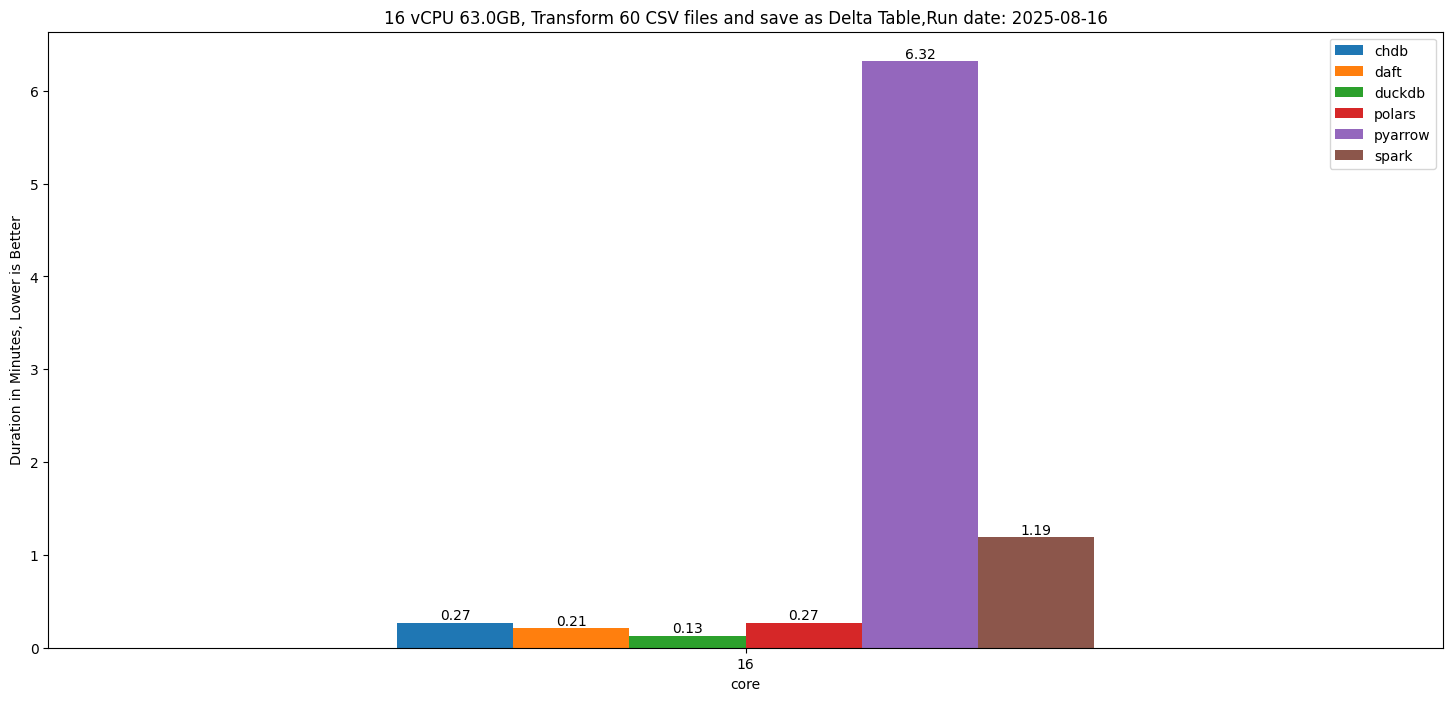

In [36]:
vCPU = str(cpu_count()) + " vCPU"
mem=round(virtual_memory().total/(1024 * 1024 * 1024),0)
runtime = vCPU+' '+str(mem)+'GB'+ f', Transform {total_files} CSV files and save as Delta Table,Run date: '+ str(time.strftime("%Y-%m-%d"))
result = duckdb.sql(f"""
            with raw as (select Engine,core, avg(duration) as duration from delta_scan('{performance_result}') where total_files = {total_files} group by all),
            result as (select Engine,core, round(sum(duration)/60,2) as duration from raw group by all order by duration)
            pivot result on Engine using avg(duration) order by core
                    """).df()
ax = result.plot.bar(rot=0,x='core',title=runtime,ylabel='Duration in Minutes, Lower is Better',figsize=(18,8))
for c in ax.containers:
    ax.bar_label(c, label_type='edge')